In [35]:

from torch.cuda import amp
from PIL import Image
import torch
import glob
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os

In [36]:

import matplotlib
import matplotlib.pyplot as plt
import time
import h5py
#import srcnn
import torch.optim as optim
import torch.nn as nn
import math
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.utils import save_image
%matplotlib inline

import torchvision.utils as vutils
import torch.nn.functional as F


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
train_lr_path='DIV2K_train_LR_x8'
train_hr_path='DIV2K_train_HR'
valid_lr_path='DIV2K_valid_LR_x8'
valid_hr_path='DIV2K_valid_HR'

model_path='model/model.net'

In [38]:
def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [39]:

#img = Image.open(train_lr_path+'/*.jpg')
#img.show()

#tf_img=transforms.ToTensor(img)

#print(tf_img.size())

In [40]:
class Dataset(Dataset):
    def __init__(self, lr_path,hr_path,lr_transform=None,hr_transform=None):
        self.lr_path=lr_path
        self.hr_path=hr_path
        self.lr_list=glob.glob(self.lr_path+'/*.jpg')
        self.hr_list=glob.glob(self.hr_path+'/*.jpg')   
        self.lr_transform=lr_transform
        self.hr_transform=hr_transform
    def __len__(self):
        return len(self.lr_list)

    def __getitem__(self, index):
        lr_path=self.lr_list[index]
        hr_path=self.hr_list[index]
        lr_img=Image.open(lr_path).convert('RGB')
        hr_img=Image.open(hr_path).convert('RGB')

        if self.lr_transform is not None:
              lr_img = self.lr_transform(lr_img)
              hr_img = self.hr_transform(hr_img)
        return lr_img,hr_img
            

In [41]:
lr_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((150,150)),
            #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )
hr_transform = transforms.Compose(
        [
            transforms.ToTensor(), 
            transforms.Resize((300,300)),        
            #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )


# 데이터셋 생성
train_ds = Dataset(train_lr_path, train_hr_path,lr_transform,hr_transform)
val_ds = Dataset(valid_lr_path, valid_hr_path,lr_transform,hr_transform)

# 데이터로더 생성
train_dl = DataLoader(train_ds, batch_size=16)
val_dl = DataLoader(val_ds, batch_size=16)

# 데이터 체크
for x, y in train_dl:
    print(x.shape, y.shape)
    break
     

torch.Size([16, 3, 150, 150]) torch.Size([16, 3, 300, 300])


In [42]:

class FSRCNN(nn.Module):
    def __init__(self, scale_factor=2, num_channels=3, d=56, s=12, m=4):
        super(FSRCNN, self).__init__()
        self.extract_features = nn.Sequential(
            nn.Conv2d(num_channels, d, kernel_size=5, padding=5//2),
            nn.PReLU()
        )

        self.shrink = nn.Sequential(
            nn.Conv2d(d, s, kernel_size=1),
            nn.PReLU()
        )

        self.map = []
        for _ in range(m):
            self.map.extend([nn.Conv2d(s, s, kernel_size=3, padding=3//2)])
            self.map.extend([nn.PReLU()])
        self.map = nn.Sequential(*self.map)

        self.expand = nn.Sequential(
            nn.Conv2d(s, d, kernel_size=1),
            nn.PReLU()
        )
        self.deconv = nn.ConvTranspose2d(d, num_channels, kernel_size=9, stride=scale_factor, padding=9//2, output_padding=scale_factor-1)

    @amp.autocast()
    def forward(self, x):
        x = self.extract_features(x)
        x = self.shrink(x)
        x = self.map(x)
        x = self.expand(x)
        x = self.deconv(x)
        return x

In [43]:
# FSRCNN 모델 경량화
class FSRCNN_x(nn.Module):
    """
        - d : the LR feature dimension
        - s : the number of shrinking filters
        - m : the mapping depth
    """
    def __init__(self, scale_factor=2, num_channels=3, d=56, s=12, m=4):
        super(FSRCNN_x, self).__init__()
        self.first_part = nn.Sequential(
            # Feature extraction (num_channels -> d)
            nn.Conv2d(num_channels, d, kernel_size=3, padding=3//2),
            nn.PReLU(d)
        )
        ###########################################################################

        # 두 개의 convolution 사이에 사용되어 연결 수(파라미터)를 줄임 => 모델 크기 감소 => 네트워크 속도 향상 => SRCNN보다 빠름
        # Shrinking (d -> s)
        self.mid_part = [nn.Conv2d(d, s, kernel_size=1), nn.PReLU(s)]
        
        ###########################################################################

        for _ in range(m):
            # Mapping (s -> s)
            # 일관성을 위해 모든 mapping layers는 같은 filter 수를 가짐
            self.mid_part.extend([nn.Conv2d(s, s, kernel_size=3, padding=3//2), nn.PReLU(s)])
        ###########################################################################

        # Expanding (shrinking layer와 정반대 process)
        self.mid_part.extend([nn.Conv2d(s, d, kernel_size=1), nn.PReLU(d)])
        
        self.mid_part = nn.Sequential(*self.mid_part)
        
        ###########################################################################

        # Deconvolution (=> upsampling)
        # nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, bias=True, dilation=1, padding_mode='zeros')
        # SRCNN의 first layer와 같은 구성의 9x9 filter를 사용
        # deconvolution filter의 패턴이 SRCNN의 first layer와 매우 비슷함
        # 각각의 픽셀 주위에 zero-padding 추가 -> convolution 연산 진행
        self.last_part = nn.ConvTranspose2d(d, num_channels, kernel_size=3, stride=scale_factor, dilation=1, padding=3//2,
                                            output_padding=scale_factor-1)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.first_part:
            if isinstance(m, nn.Conv2d):
                # nn.init.normal_(tensor, mean=0.0, std=1.0) 입력 Tensor를 정규 분포에서 가져온 값으로 채움
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        for m in self.mid_part:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        nn.init.normal_(self.last_part.weight.data, mean=0.0, std=0.001)
        nn.init.zeros_(self.last_part.bias.data)
    
    def forward(self, x):
        x = self.first_part(x)
        x = self.mid_part(x)
        x = self.last_part(x)
        return x

##################################################################################################################################

class FSRCNN_s(nn.Module):
    # d : the LR feature dimension, s : the number of shrinking filters, m : the mapping depth,
    def __init__(self, scale_factor, num_channels=1, d=150, s=5, m=1):
        super(FSRCNN_s, self).__init__()
        self.first_part = nn.Sequential(
            # Feature extraction (num_channels -> d)
            nn.Conv2d(num_channels, d, kernel_size=3, padding=3//2),
            nn.ReLU(d)
        )
        ###########################################################################

        # 두 개의 convolution 사이에 사용되어 연결 수(파라미터)를 줄임 => 모델 크기 감소 => 네트워크 속도 향상 => SRCNN보다 빠름
        # Shrinking (d -> s)
        self.mid_part = [nn.Conv2d(d, s, kernel_size=1), nn.ReLU(s)]
        
        ###########################################################################

        for _ in range(m):
            # Mapping (s -> s)
            # 일관성을 위해 모든 mapping layers는 같은 filter 수를 가짐
            self.mid_part.extend([nn.Conv2d(s, s, kernel_size=3, padding=3//2), nn.ReLU(s)])
        ###########################################################################

        # Expanding (shrinking layer와 정반대 process)
        self.mid_part.extend([nn.Conv2d(s, d, kernel_size=1), nn.ReLU(d)])
        
        self.mid_part = nn.Sequential(*self.mid_part)
        
        ###########################################################################

        # Deconvolution (=> upsampling)
        # nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, bias=True, dilation=1, padding_mode='zeros')
        # SRCNN의 first layer와 같은 구성의 9x9 filter를 사용
        # deconvolution filter의 패턴이 SRCNN의 first layer와 매우 비슷함
        # 각각의 픽셀 주위에 zero-padding 추가 -> convolution 연산 진행
        self.last_part = nn.ConvTranspose2d(d, num_channels, kernel_size=3, stride=scale_factor, dilation=1, padding=3//2,
                                            output_padding=scale_factor-1)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.first_part:
            if isinstance(m, nn.Conv2d):
                # nn.init.normal_(tensor, mean=0.0, std=1.0) 입력 Tensor를 정규 분포에서 가져온 값으로 채움
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        for m in self.mid_part:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        nn.init.normal_(self.last_part.weight.data, mean=0.0, std=0.001)
        nn.init.zeros_(self.last_part.bias.data)
    
    def forward(self, x):
        x = self.first_part(x)
        x = self.mid_part(x)
        x = self.last_part(x)
        return x
    


In [45]:

learning_rate=0.002
training_epochs=10

In [110]:
model=FSRCNN_x(scale_factor=2).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion=nn.MSELoss().to(device)

In [111]:
from torchsummary import summary as summary

summary(model, (3,150,150)) # (model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 56, 150, 150]           1,568
             PReLU-2         [-1, 56, 150, 150]              56
            Conv2d-3         [-1, 12, 150, 150]             684
             PReLU-4         [-1, 12, 150, 150]              12
            Conv2d-5         [-1, 12, 150, 150]           1,308
             PReLU-6         [-1, 12, 150, 150]              12
            Conv2d-7         [-1, 12, 150, 150]           1,308
             PReLU-8         [-1, 12, 150, 150]              12
            Conv2d-9         [-1, 12, 150, 150]           1,308
            PReLU-10         [-1, 12, 150, 150]              12
           Conv2d-11         [-1, 12, 150, 150]           1,308
            PReLU-12         [-1, 12, 150, 150]              12
           Conv2d-13         [-1, 56, 150, 150]             728
            PReLU-14         [-1, 56, 1

In [112]:
def psnr(label, outputs, max_val=1.):
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff)**2))
    if rmse == 0: # label과 output이 완전히 일치하는 경우
        return 100
    else:
        psnr = 20 * math.log10(max_val/rmse)
        return psnr
     

In [113]:
from copy import deepcopy
loss_list = []
acc_list = []
best_acc = 0
best_f1 = 0
best_acc_model = None 
best_f1_model = None
from sklearn.metrics import f1_score,accuracy_score

In [114]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for batch_idx, (lr, hr) in enumerate(train_loader):
        #print(data.shape,target.shape)
        lr, hr = lr.to(device), hr.to(device)
       
        optimizer.zero_grad()
        output = model(lr)
        loss = criterion(output, hr)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(lr), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
        running_loss += loss.item()
        batch_psnr = psnr(output, hr)
        running_psnr += batch_psnr
    
    final_loss = running_loss / len(train_loader.dataset)
    final_psnr = running_psnr / int(len(train_ds)/train_loader.batch_size)
    return final_loss, final_psnr
            
# ## Validation set 으로 테스트하기

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    running_loss = 0.0
    running_psnr = 0.0

    i=0
    with torch.no_grad():
        for lr, hr in test_loader:
            lr, hr = lr.to(device), hr.to(device)
            preds = model(lr)
            # 배치 오차를 합산
            test_loss += criterion(preds, hr).item()

            batch_psnr = psnr(preds, hr)
            running_psnr += batch_psnr
 

            vutils.save_image(
                    lr.detach(), os.path.join('outputs', f"LR_{i}.jpg")
                )
            vutils.save_image(
                    hr.detach(), os.path.join('outputs', f"HR_{i}.jpg")
                )
            vutils.save_image(
                    preds.detach(), os.path.join('outputs', f"preds_{i}.jpg")
                )
            i+=1
    test_loss /= len(test_loader.dataset)
    final_psnr = running_psnr / int(len(val_ds)/test_loader.batch_size)
    return test_loss,final_psnr

In [115]:
num_epochs = 10

# 학습하기
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} of {num_epochs}')
    train_epoch_loss, train_epoch_psnr = train(model, train_dl,optimizer,num_epochs)
    val_epoch_loss, val_epoch_psnr = evaluate(model, val_dl)

    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
    end = time.time()
    print(f'Train PSNR: {train_epoch_psnr:.3f}, Val PSNR: {val_epoch_psnr:.3f}, Time: {end-start:.2f} sec')
    
    


Epoch 1 of 10
Train Epoch: 10 [0/800 (0%)]	Loss: 0.252230
Train Epoch: 10 [160/800 (20%)]	Loss: 0.043019
Train Epoch: 10 [320/800 (40%)]	Loss: 0.028631
Train Epoch: 10 [480/800 (60%)]	Loss: 0.019099
Train Epoch: 10 [640/800 (80%)]	Loss: 0.023695
Train PSNR: 14.640, Val PSNR: 19.412, Time: 106.58 sec
Epoch 2 of 10
Train Epoch: 10 [0/800 (0%)]	Loss: 0.019965
Train Epoch: 10 [160/800 (20%)]	Loss: 0.019126
Train Epoch: 10 [320/800 (40%)]	Loss: 0.020618
Train Epoch: 10 [480/800 (60%)]	Loss: 0.014697
Train Epoch: 10 [640/800 (80%)]	Loss: 0.017176
Train PSNR: 17.356, Val PSNR: 21.500, Time: 236.29 sec
Epoch 3 of 10
Train Epoch: 10 [0/800 (0%)]	Loss: 0.012714
Train Epoch: 10 [160/800 (20%)]	Loss: 0.012097
Train Epoch: 10 [320/800 (40%)]	Loss: 0.012960
Train Epoch: 10 [480/800 (60%)]	Loss: 0.010139
Train Epoch: 10 [640/800 (80%)]	Loss: 0.011813
Train PSNR: 19.188, Val PSNR: 22.649, Time: 357.70 sec
Epoch 4 of 10
Train Epoch: 10 [0/800 (0%)]	Loss: 0.010768
Train Epoch: 10 [160/800 (20%)]	Loss: 0

In [116]:
torch.save(model.state_dict(), model_path)


In [117]:
torch.save(model, model_path)

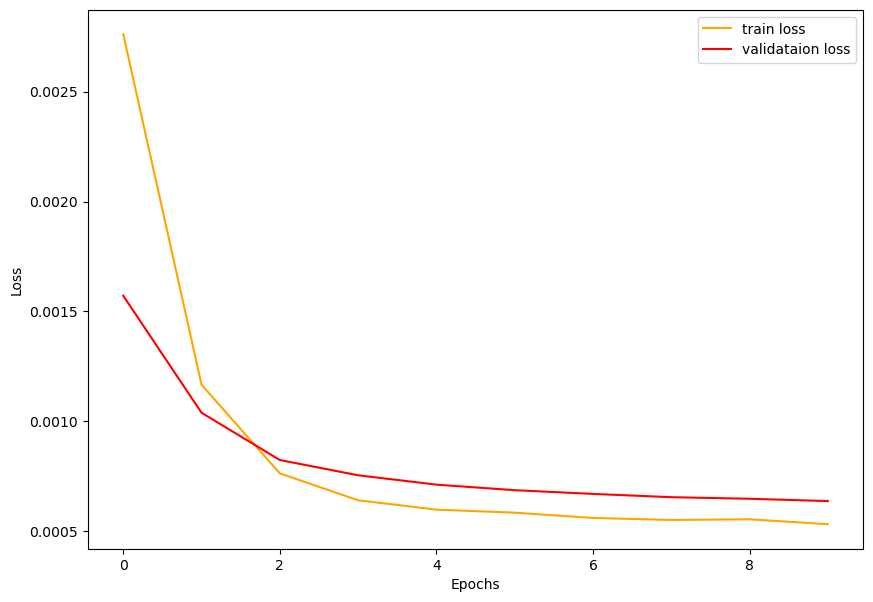

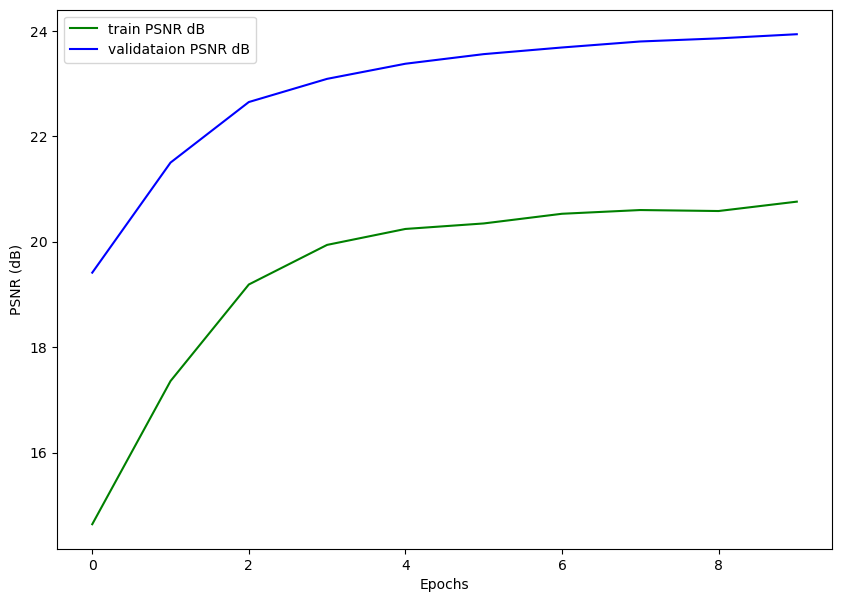

In [118]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# psnr plots
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.show()

Text(0.5, 1.0, 'ground_truth')

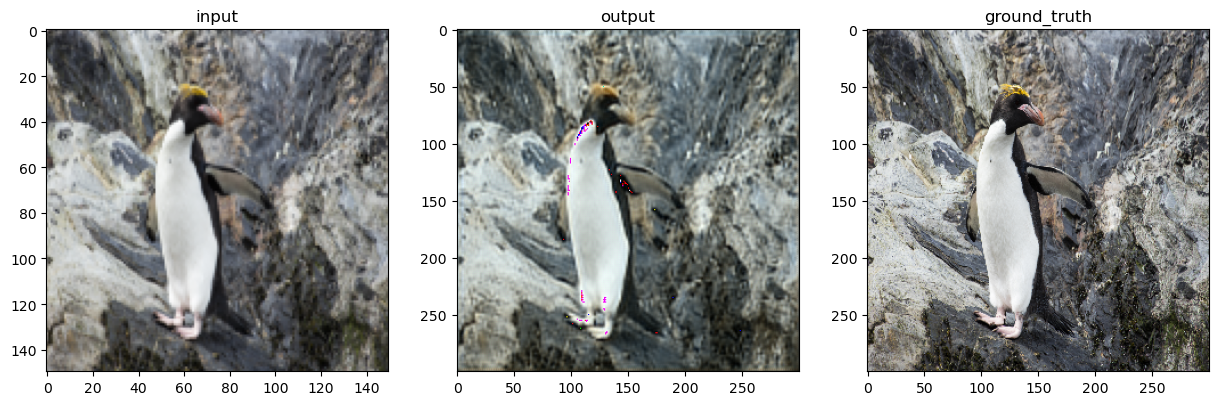

In [120]:
from torchvision.transforms.functional import to_pil_image
# 이미지 꺼내기
for img, label in val_dl:
    img = img[0]
    label = label[0]
    break

# super-resolution
model.eval()
with torch.no_grad():
    img_ = img.unsqueeze(0)
    img_ = img_.to(device)
    output = model(img_)
    output = output.squeeze(0)

# 시각화
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(to_pil_image(img))
plt.title('input')
plt.subplot(1,3,2)
plt.imshow(to_pil_image(output))
plt.title('output')
plt.subplot(1,3,3)
plt.imshow(to_pil_image(label))
plt.title('ground_truth')

In [122]:
import cv2
import math
from torch.autograd import Variable

frame_list=[]

n_frame=0

capture = cv2.VideoCapture(0,cv2.CAP_DSHOW)
capture.set(cv2.CAP_PROP_FRAME_WIDTH, 300)
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 300)
tf_toTensor = transforms.ToTensor() 
tf_toPILImage = transforms.ToPILImage() 
while cv2.waitKey(33) < 0:
    start=time.time()
    ret, frame = capture.read()
    original=cv2.resize(frame,(300,300))
    frame = Image.fromarray(frame)
    frame = frame.resize((150,150))
    
    content_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.mul(255))
        ])
    content_image=content_transform(frame)
    content_image = content_image.unsqueeze(0)
    
    if torch.cuda.is_available():
        content_image = content_image.cuda()
    content_image = Variable(content_image, volatile=True)
    

    output = model(content_image)
    
    if torch.cuda.is_available():
         output = output.cpu()
    output_data = output.data[0]
    
    end = time.time()
    print("Processed frame %d" %n_frame)
    print("FPS = %f" %(1/(end - start)))
    
    frame_list.append((1/(end - start)))
    n_frame+=1
    
    frame = output_data.clone().clamp(0, 255).numpy()
    frame = frame.transpose(1, 2, 0).astype("uint8")

    show=np.hstack((original[100:250,100:250],frame[100:250,100:250]))
    cv2.imshow("Output", show)

capture.release()
cv2.destroyAllWindows()

print("평균 fps:",np.mean(frame_list))

C:\Users\ezspl\AppData\Local\Temp\ipykernel_1812\1092881071.py:30: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  content_image = Variable(content_image, volatile=True)


Processed frame 0
FPS = 2.645504
Processed frame 1
FPS = 199.919161
Processed frame 2
FPS = 43.479609
Processed frame 3
FPS = 37.037105
Processed frame 4
FPS = 35.711097
Processed frame 5
FPS = 33.332835
Processed frame 6
FPS = 37.038413
Processed frame 7
FPS = 22.223362
Processed frame 8
FPS = 34.482706
Processed frame 9
FPS = 37.039395
Processed frame 10
FPS = 35.716874
Processed frame 11
FPS = 40.002136
Processed frame 12
FPS = 34.482139
Processed frame 13
FPS = 23.255436
Processed frame 14
FPS = 35.711401
Processed frame 15
FPS = 32.259410
Processed frame 16
FPS = 38.460799
Processed frame 17
FPS = 35.715962
Processed frame 18
FPS = 22.725349
Processed frame 19
FPS = 34.483840
Processed frame 20
FPS = 249.928733
Processed frame 21
FPS = 58.822018
Processed frame 22
FPS = 34.484408
Processed frame 23
FPS = 23.810709
Processed frame 24
FPS = 34.481856
Processed frame 25
FPS = 35.712921
Processed frame 26
FPS = 37.039067
Processed frame 27
FPS = 35.708968
Processed frame 28
FPS = 37.0